In [2]:
pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from osgeo import gdal, ogr

In [17]:
large_image_stack = gdal.Open(r'/content/drive/MyDrive/LULC/VH_Energy.tif')


x = large_image_stack
print(large_image_stack)
band1 = x.GetRasterBand(1) # Red channel
# band2 = x.GetRasterBand(2)

b1 = band1.ReadAsArray()
# b2 = band2.ReadAsArray()

large_image_stack = np.dstack((b1))

# large_mask_stack = gdal.Open(r'/content/drive/MyDrive/LULC/RF1.tif')

# x = large_mask_stack
# band1 = x.GetRasterBand(1) # Red channel
# # band2 = x.GetRasterBand(2)

# b1 = band1.ReadAsArray()
# # b2 = band2.ReadAsArray()

# large_mask_stack = np.dstack((b1))
# # print(np.unique(large_mask_stack, return_counts=True))

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f5aed93af30> >


In [13]:
print(np.unique(large_mask_stack, return_counts=True))


(array([0., 1., 2., 3.], dtype=float32), array([21395691,  1482408,  2679604, 31275382]))


In [11]:
large_mask_stack = np.where(large_mask_stack==-1, 3, large_mask_stack)

In [12]:
large_mask_stack.shape

(1, 8929, 6365)

In [18]:
patches_img = patchify(large_image_stack[0], (512, 512), step=512) 
# patches_msk = patchify(large_mask_stack[0], (512, 512), step=512) 

In [19]:
img = 0
for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    # single_patch_msk = patches_msk[i,j,:,:]
    # if -1 not in single_patch_img:
    # tiff.imwrite('/content/drive/MyDrive/LULC/msk1/' + 'image_' + str(img) + '_' + str(i)+ '_' + str(j)+ ".tif",single_patch_msk)
    tiff.imwrite('/content/drive/MyDrive/LULC/img1_energy/' + 'image_' + str(img) + '_' + str(i)+ '_' + str(j)+ ".tif", patches_img[i,j,:,:])
    img +=1

In [16]:
img

204

In [14]:
single_patch_img = patches_msk[0,0,:,:]
# a = single_patch_img[:,:,:,0]
# print(a[0].shape)
print((-1 not in single_patch_img))
#x = single_patch_img[]

False


In [9]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [10]:
from keras.utils.np_utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [11]:
#Resizing images, if needed
SIZE_X = 512 
SIZE_Y = 512
n_classes=4 #Number of classes for segmentation

#Capture training image info as a list
train_images = []
count = 100
for directory_path in glob.glob("/content/drive/MyDrive/LULC/img1_max/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        if count >= 0:
          img = cv2.imread(img_path, -1)       
          # img = cv2.resize(img, (SIZE_Y, SIZE_X))
          train_images.append(img)
          count-=1
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)
count = 100

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("/content/drive/MyDrive/LULC/msk1/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        if count >= 0:
          mask = cv2.imread(mask_path, -1)       
          # mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
          train_masks.append(mask)
          count-=1

        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [12]:
import random
# a = random.randint(0,200)
print(np.unique(train_masks, return_counts=True))
print(np.unique(train_images, return_counts=True))
train_images = np.nan_to_num(train_images)
print(np.unique(train_images, return_counts=True))

(array([0., 1., 2., 3.], dtype=float32), array([ 9294162,   600367,  2081738, 14500277]))
(array([0.01428571, 0.02142857, 0.02586207, 0.02857143, 0.0326087 ,
       0.03448276, 0.03571429, 0.04285714, 0.04310345, 0.04347826,
       0.04411765, 0.04545455, 0.05      , 0.05172414, 0.05434782,
       0.05714286, 0.05882353, 0.06034483, 0.06428572, 0.06521739,
       0.06818182, 0.06896552, 0.07142857, 0.07352941, 0.07608695,
       0.0775862 , 0.07857143, 0.08571429, 0.0862069 , 0.08695652,
       0.0882353 , 0.09090909, 0.09285714, 0.09482758, 0.09782609,
       0.1       , 0.10294118, 0.10344828, 0.10714286, 0.10869565,
       0.11206897, 0.11363637, 0.11428571, 0.11764706, 0.11956522,
       0.12068965, 0.12142857, 0.12857144, 0.12931034, 0.13043478,
       0.13235295, 0.13571429, 0.13636364, 0.13793103, 0.14130434,
       0.14285715, 0.14655173, 0.14705883, 0.15      , 0.1521739 ,
       0.15517241, 0.15714286, 0.1590909 , 0.16176471, 0.16304348,
       0.1637931 , 0.16428572, 0.17142

In [13]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.1, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))



###############################################################
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced', np.unique(train_masks_reshaped_encoded), train_masks_reshaped_encoded)
# print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)


# model.save('test.hdf5')
# model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')
############################################################
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


##################################
#model = get_model()
# model.load_weights('sandstone_50_epochs_catXentropy_acc.hdf5')  
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')  

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = n_classes
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[3,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[0,4]+ values[1,4]+ values[3,4])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

#####################################################################

#Predict on large image

#Apply a trained model on large image

from patchify import patchify, unpatchify

large_image = cv2.imread('large_images/large_image.tif', 0)
#This will split the image into small images of shape [3,3]
patches = patchify(large_image, (128, 128), step=128)  #Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print(i,j)
        
        single_patch = patches[i,j,:,:]       
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
        single_patch_input=np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
plt.imshow(reconstructed_image, cmap='gray')
#plt.imsave('data/results/segm.jpg', reconstructed_image, cmap='gray')

plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='jet')
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


##################################
#model = get_model()
model.load_weights('sandstone_50_epochs_catXentropy_acc.hdf5')  
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')  

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class5 is: ", class5_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

#####################################################################

#Predict on large image

#Apply a trained model on large image

# from patchify import patchify, unpatchify

# large_image = cv2.imread('large_images/large_image.tif', 0)
# #This will split the image into small images of shape [3,3]
# patches = patchify(large_image, (128, 128), step=128)  #Step=256 for 256 patches means no overlap

# predicted_patches = []
# for i in range(patches.shape[0]):
#     for j in range(patches.shape[1]):
#         print(i,j)
        
#         single_patch = patches[i,j,:,:]       
#         single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
#         single_patch_input=np.expand_dims(single_patch_norm, 0)
#         single_patch_prediction = (model.predict(single_patch_input))
#         single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

#         predicted_patches.append(single_patch_predicted_img)

# predicted_patches = np.array(predicted_patches)

# predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )

# reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
# plt.imshow(reconstructed_image, cmap='gray')
# #plt.imsave('data/results/segm.jpg', reconstructed_image, cmap='gray')

# plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

# # final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# # plt.imshow(final_prediction)

# plt.figure(figsize=(8, 8))
# plt.subplot(221)
# plt.title('Large Image')
# plt.imshow(large_image, cmap='gray')
# plt.subplot(222)
# plt.title('Prediction of large Image')
# plt.imshow(reconstructed_image, cmap='jet')
# plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class values in the dataset are ...  [0 1 2 3]
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 512, 512, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 512, 512, 16  0           ['conv2d_38[0][0]']              
                                )            

KeyboardInterrupt: ignored

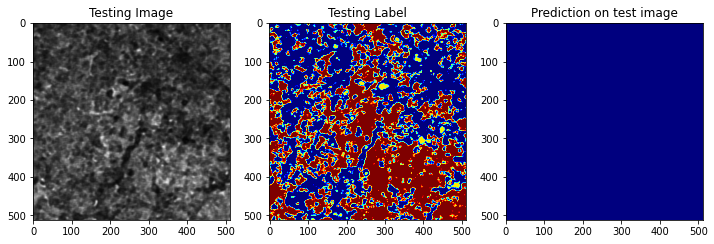

In [54]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()